# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
# Bloco de importações
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import metrics
from scipy.stats import ks_2samp
from statsmodels.tools.sm_exceptions import PerfectSeparationError

# Obtenção do caminho até o arquivo
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

# Abertura do arquivo
df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])

# Criação da Dummy a ser usada como variável-alvo
df['flag_doente'] = (df['num'] != 0).astype('int64')
df['flag_doente'] = pd.to_numeric(df['flag_doente'], errors='coerce')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [2]:
# Padrão inicial para analisar o conjunto de dados inicializado
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


In [3]:
# Passo optativo
# Valores numéricos SEM NENHUMA INFORMAÇÃO após a virgula
df['age'] = df['age'].astype(int)
df['sex'] = df['sex'].astype(int)
df['cp'] = df['cp'].astype(int)
df['trestbps'] = df['trestbps'].astype(int)
df['chol'] = df['chol'].astype(int)
df['fbs'] = df['fbs'].astype(int)
df['restecg'] = df['restecg'].astype(int)
df['thalach'] = df['thalach'].astype(int)
df['exang'] = df['exang'].astype(int)
df['oldpeak'] = df['oldpeak'].astype(int)
df['slope'] = df['slope'].astype(int)

# Colunas com valores "?" dentre os dados
df['ca'] = pd.to_numeric(df['ca'], errors = 'coerce')
df['thal'] = pd.to_numeric(df['thal'], errors = 'coerce')

# Preenchendo valores NaN com a mediana
mediana_ca = df['ca'].median()
mediana_thal = df['thal'].median()
df['ca'].fillna(mediana_ca, inplace = True)
df['thal'].fillna(mediana_thal, inplace = True)

# Convertendo para inteiro
df['ca'] = df['ca'].astype(int)
df['thal'] = df['thal'].astype(int)

# Verificar novamente as alterações
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   age          303 non-null    int32
 1   sex          303 non-null    int32
 2   cp           303 non-null    int32
 3   trestbps     303 non-null    int32
 4   chol         303 non-null    int32
 5   fbs          303 non-null    int32
 6   restecg      303 non-null    int32
 7   thalach      303 non-null    int32
 8   exang        303 non-null    int32
 9   oldpeak      303 non-null    int32
 10  slope        303 non-null    int32
 11  ca           303 non-null    int32
 12  thal         303 non-null    int32
 13  num          303 non-null    int64
 14  flag_doente  303 non-null    int64
dtypes: int32(13), int64(2)
memory usage: 20.2 KB


As variáveis qualitativas são aquelas que representam características não numéricas, como categorias ou rótulos.

Desta forma, as variáveis qualitativas são:

> **sex**

> **cp**

> **fbs**

> **restecg**

> **exang**

> **slope**

> **ca**

> **thal**

Após analisar as descrições das variáveis, optei por "restecg", "exang" e "ca"; acreditando que possam ter mais influência e abertura para importantes análises.

### 1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
- *Monte* a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
# Criando a função
def bivariada(df, alvo, var):
    tab = pd.crosstab(df[var], df[alvo], margins = True)
    tab['Fração de doentes'] = round(tab[1] / tab['All'], 2)
    tab['Odds'] = round(tab[1] / tab[0], 2)
    tab['Odds ratio'] = round(tab['Odds'] / tab.loc['All','Odds'], 2)
    tab['Logito'] = round(np.log(tab['Odds']), 2)
    tab['LOG Odds Ratio'] = round(np.log(tab['Odds ratio']), 2)
    tab['W.O.E.'] = round(tab['LOG Odds Ratio'] * tab['Fração de doentes'], 2)
    return tab

# Montando as bivariadas nas variaveis qualitativas escolhidas previamente
tab_restecg = bivariada(df = df, alvo = 'flag_doente', var = 'restecg')
tab_exang = bivariada(df = df, alvo = 'flag_doente', var = 'exang')
tab_ca = bivariada(df = df, alvo = 'flag_doente', var = 'ca')

tab_restecg

flag_doente,0,1,All,Fração de doentes,Odds,Odds ratio,Logito,LOG Odds Ratio,W.O.E.
restecg,,,,,,,,,
0,95,56,151,0.37,0.59,0.69,-0.53,-0.37,-0.14
1,1,3,4,0.75,3.00,3.53,1.10,1.26,0.94
2,68,80,148,0.54,1.18,1.39,0.17,0.33,0.18
All,164,139,303,0.46,0.85,1.00,-0.16,0.00,0.00


In [5]:
tab_exang

flag_doente,0,1,All,Fração de doentes,Odds,Odds ratio,Logito,LOG Odds Ratio,W.O.E.
exang,,,,,,,,,
0,141,63,204,0.31,0.45,0.53,-0.80,-0.63,-0.20
1,23,76,99,0.77,3.30,3.88,1.19,1.36,1.05
All,164,139,303,0.46,0.85,1.00,-0.16,0.00,0.00


In [6]:
tab_ca

flag_doente,0,1,All,Fração de doentes,Odds,Odds ratio,Logito,LOG Odds Ratio,W.O.E.
ca,,,,,,,,,
0,133,47,180,0.26,0.35,0.41,-1.05,-0.89,-0.23
1,21,44,65,0.68,2.10,2.47,0.74,0.90,0.61
2,7,31,38,0.82,4.43,5.21,1.49,1.65,1.35
3,3,17,20,0.85,5.67,6.67,1.74,1.90,1.62
All,164,139,303,0.46,0.85,1.00,-0.16,0.00,0.00


> Conforme as bivariadas apresentam, nota-se que a variável explicativa "**ca**" (**número de vasos principais coloridos por fluorosopia**) é a mais significativa na descriminação da flag, uma vez que o Peso de sua Evidência é multiplas vezes maior do que as outras variáveis explicativas.

### 2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [7]:
# Criando a segunda função
def bivar_particionada(df, alvo, var, num_cat = 5):
    df['group'] = pd.qcut(df[var], num_cat, duplicates = 'drop')
    tab = pd.crosstab(df['group'], df[alvo], margins = True)
    tab['Fração de doentes'] = round(tab[1] / tab['All'], 2)
    tab['Odds'] = round(tab[1] / tab[0], 2)
    tab['Odds ratio'] = round(tab['Odds'] / tab.loc['All','Odds'], 2)
    tab['Logito'] = round(np.log(tab['Odds']), 2)
    tab['LOG Odds Ratio'] = round(np.log(tab['Odds ratio']), 2)
    tab['W.O.E.'] = round(tab['LOG Odds Ratio'] * tab['Fração de doentes'], 2)
    return tab

tab_5 = bivar_particionada(df = df, alvo = 'flag_doente', var = 'age')
tab_5

flag_doente,0,1,All,Fração de doentes,Odds,Odds ratio,Logito,LOG Odds Ratio,W.O.E.
group,,,,,,,,,
"(28.999, 45.0]",47,16,63,0.25,0.34,0.40,-1.08,-0.92,-0.23
"(45.0, 53.0]",42,22,64,0.34,0.52,0.61,-0.65,-0.49,-0.17
"(53.0, 58.0]",32,39,71,0.55,1.22,1.44,0.20,0.36,0.20
"(58.0, 62.0]",13,32,45,0.71,2.46,2.89,0.90,1.06,0.75
"(62.0, 77.0]",30,30,60,0.50,1.00,1.18,0.00,0.17,0.08
All,164,139,303,0.46,0.85,1.00,-0.16,0.00,0.00


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [8]:
LR = smf.logit('flag_doente ~ C(sex) + C(cp) + trestbps + age', data = df).fit()

LR.summary()

Optimization terminated successfully.
         Current function value: 0.476154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      296
Method:                           MLE   Df Model:                            6
Date:                Tue, 02 Jan 2024   Pseudo R-squ.:                  0.3097
Time:                        22:11:36   Log-Likelihood:                -144.27
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.692e-25
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -8.3407      1.621     -5.145      0.000     -11.518      -5.163
C(sex)[T.1]     1.8094      0.353      5.130      0.000       1.118       2.501
C(cp)[T.2]     -0.0617      0.636     -0.097      0.923      -1.309       1.186
C(cp)[T.3]      0.0715      0.573      0.125      0.901      -1.051       1.194
C(cp)[T.4]      2.4789      0.553      4.485      0.000       1.396       3.562
trestbps        0.0193      0.009      2.261      0.024       0.003       0.036
age             0.0567      0.018      3.120      0.002       0.021       0.092
===============================================================================
"""

> O sexo apresenta uma associação estatisticamente significativa com a presença de doença cardíaca, indicando que homens têm uma probabilidade estimada significativamente maior de desenvolver a doença em comparação com mulheres.

> Além disso, observa-se que a variável 'trestbps' está positivamente associada à presença de doença cardíaca, sugerindo que a probabilidade estimada de ocorrência da doença aumenta com o aumento da pressão sanguínea em repouso. Da mesma forma, a variável 'age' também apresenta uma associação positiva, indicando que a probabilidade estimada de doença cardíaca aumenta com o envelhecimento.

> No que diz respeito aos pacientes com dor no peito, representada pela variável 'cp', identifica-se diferentes associações com a presença de doença cardíaca. Porém, apenas pacientes assintomáticos (4) em relação à dor no peito mostram uma probabilidade estimada maior de doença cardíaca em comparação com pacientes sintomáticos (1), (2) & (3).

> No entanto, é crucial considerar que a interpretação precisa dessas associações pode depender dos detalhes específicos da codificação da variável 'cp'. Esses resultados destacam a importância de uma análise aprofundada para compreender completamente as relações entre as variáveis e a presença de doença cardíaca.

## 4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

Text(0.5, 0, 'Grupo')

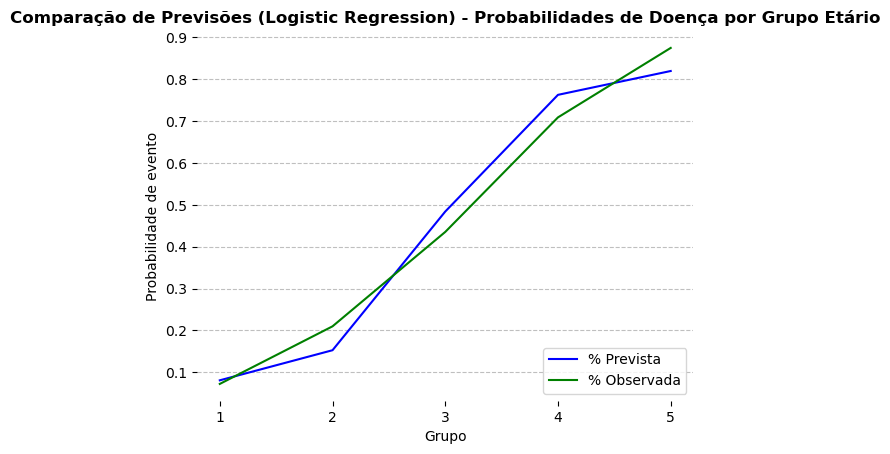

In [9]:
# Calculando a prob do evento conforme o modelo preditivo
df['predito'] = LR.predict(df)

# Categorizando em 5 grupos
cat_pred = pd.qcut(df['predito'], 5, duplicates = 'drop')

# Obtendo a média por grupo usando o grupby
aux = df.groupby(cat_pred)
g5 = aux[['flag_doente']].count().rename(columns = {'flag_doente': 'contagem'})
g5['previsão média'] = aux['predito'].mean()

# Porcentagem de sobreviventes por faixa
g5['pct_sobrev'] = aux['flag_doente'].mean()

# Comparação grafica ESPERADO x OBSERVADO
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Comparação de Previsões (Logistic Regression) - Probabilidades de Doença por Grupo Etário',
             fontweight = 'bold')

ax = g5['pct_sobrev'].plot(label = '% Prevista', color = 'blue')
ax = g5['previsão média'].plot(label='% Observada', color = 'green')

# Adicionando linhas guia
ax.grid(axis = 'y', linestyle = '--', color = 'grey', alpha = 0.5)

# Removendo bordas do gráfico
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Ajuste fino na exibição do gráfico
ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc = "lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

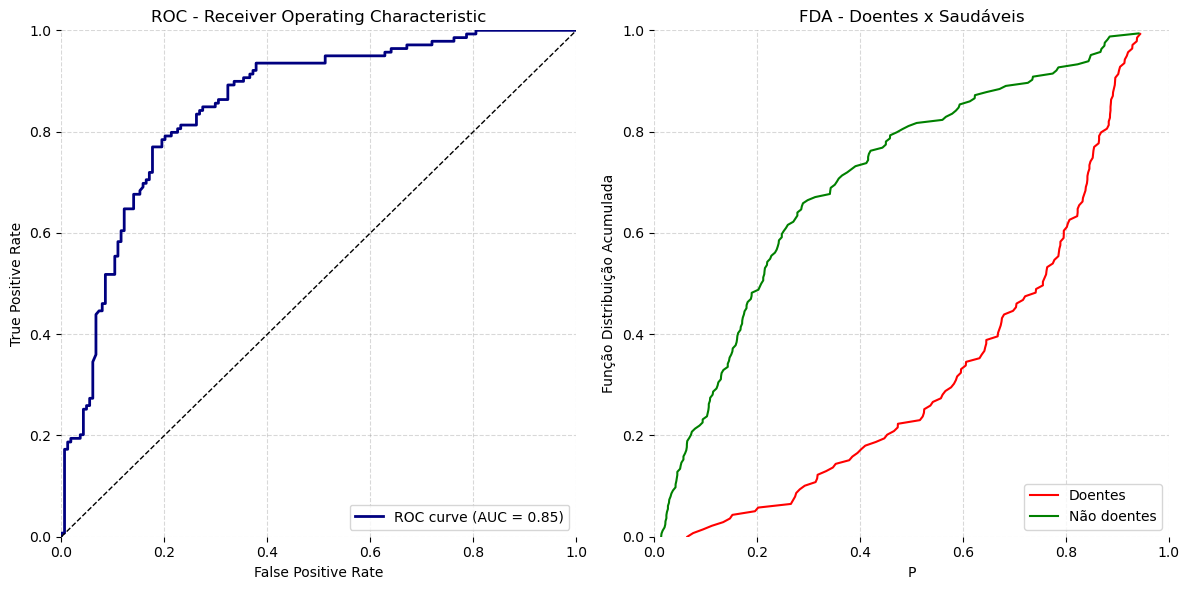

,Acurácia (%),GINI (%),KS (%)
antes,79.5,70.4,59.3
depois,NaN,NaN,NaN
variacao,NaN,NaN,NaN


In [10]:
# Servirá de tabela comparativa
comparativos = pd.DataFrame(index = ['antes', 'depois', 'variacao'])

# Exibição dos gráficos
# ROC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)

# Criando a figura e os eixos
fig, ax = plt.subplots(figsize = (12, 6), ncols = 2)

ax[0].plot(fpr, tpr, color = 'navy', lw = 2, label = 'ROC curve (AUC = %0.2f)' % auc_)
ax[0].plot([0, 1], [0, 1], color = 'black', lw = 1, linestyle = '--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.0])
ax[0].grid(axis = 'x', linestyle = '--', color = 'gray', alpha = 0.3)
ax[0].grid(axis = 'y', linestyle = '--', color = 'gray', alpha = 0.3)
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC - Receiver Operating Characteristic')
ax[0].legend(loc = "lower right")

# Removendo bordas do gráfico
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

# Função de Distribuição Acumulada
score_pop1 = df.loc[df['flag_doente'] == 1, 'predito']
ax[1].plot(np.sort(score_pop1),
           np.linspace(0, 1, len(score_pop1), endpoint = False),
           label = 'Doentes',
           color = 'red')
score_pop2 = df.loc[df['flag_doente'] != 1, 'predito']
ax[1].plot(np.sort(score_pop2),
           np.linspace(0, 1, len(score_pop2), endpoint = False),
           label = 'Não doentes',
           color = 'green')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.0])
ax[1].grid(axis = 'x', linestyle = '--', color = 'gray', alpha = 0.3)
ax[1].grid(axis = 'y', linestyle = '--', color = 'gray', alpha = 0.3)
ax[1].set_xlabel('P')
ax[1].set_ylabel('Função Distribuição Acumulada')
ax[1].set_title('FDA - Doentes x Saudáveis')
ax[1].legend(loc = "lower right")

# Removendo bordas do gráfico
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

plt.tight_layout()
plt.show()

# Exibição das métricas
acc = metrics.accuracy_score(df['flag_doente'], df['predito'] > 0.5)
gini = 2 * auc_ - 1
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

# Adiciona as métricas ao DataFrame
comparativos.loc['antes', 'Acurácia (%)'] = acc * 100
comparativos.loc['antes', 'GINI (%)'] = gini * 100
comparativos.loc['antes', 'KS (%)'] = ks * 100

round(comparativos, 1)

6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [11]:
%%time

# Definindo as variáveis explicativas iniciais
inicial = ['sex', 'cp', 'trestbps', 'age']

# Inicializando o modelo anterior
LR = sm.Logit(df['flag_doente'], sm.add_constant(df[inicial])).fit()

# Criando uma função stepwise para inserir/remover variáveis para mim conforme alpha = 5%
def auto_selecao_stepwise(dados, resposta, variaveis_iniciais):
    # Excluindo as variáveis indesejadas
    nao_var = ['num', 'flag_doente', 'group', 'predito']
    dados = dados.drop(columns = nao_var)
    inclusas = list(variaveis_iniciais)
    
    while True:
        mudanca = False

        # Adiciona variáveis
        exclusas = list(set(dados.columns) - set(inclusas))
        novo_pval = pd.Series(index = exclusas, dtype='float64')

        for new_var in exclusas:
            modelo = sm.Logit(resposta, sm.add_constant(dados[inclusas + [new_var]])).fit(disp = 0)
            novo_pval[new_var] = modelo.pvalues[new_var]

        melhor_pval = novo_pval.min()
        if melhor_pval < 0.05:
            melhor_feature = novo_pval.idxmin()
            inclusas.append(melhor_feature)
            mudanca = True

        # Remove variáveis
        modelo = sm.Logit(resposta, sm.add_constant(dados[inclusas])).fit(disp = 0)
        pvalores = modelo.pvalues.iloc[1:]
        pior_pval = pvalores.max()

        if pior_pval > 0.05:
            mudanca = True
            pior_feature = pvalores.idxmax()
            inclusas.remove(pior_feature)
        if not mudanca:
            break
            
    return inclusas

# Realizando o stepwise logistic regression
selecionadas = auto_selecao_stepwise(df, df['flag_doente'], inicial)

print("Variáveis selecionadas:", selecionadas)

# Criando o modelo final com as variáveis selecionadas
LR2 = sm.Logit(df['flag_doente'], sm.add_constant(df[selecionadas])).fit()

# Adicionando as previsões ao DataFrame
df['predito2'] = LR2.predict(sm.add_constant(df[selecionadas]))

# Métricas requeridas
acc2 = metrics.accuracy_score(df['flag_doente'], df['predito2'] > 0.5)
fpr2, tpr2, thresholds = metrics.roc_curve(df['flag_doente'], df['predito2'])
auc2 = metrics.auc(fpr2, tpr2)
gini2 = 2 * auc2 - 1
ks2 = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito2'], df.loc[df['flag_doente'] != 1, 'predito2']).statistic

# Adicionando as métricas depois do stepwise
comparativos.loc['depois', 'Acurácia (%)'] = acc2 * 100
comparativos.loc['depois', 'GINI (%)'] = gini2 * 100
comparativos.loc['depois', 'KS (%)'] = ks2 * 100

# Calculando e adicionando a variacao entre o "antes" e "depois"
comparativos.loc['variacao', 'Acurácia (%)'] = comparativos.loc['depois', 'Acurácia (%)'] - comparativos.loc['antes', 'Acurácia (%)']
comparativos.loc['variacao', 'GINI (%)'] = comparativos.loc['depois', 'GINI (%)'] - comparativos.loc['antes', 'GINI (%)']
comparativos.loc['variacao', 'KS (%)'] = comparativos.loc['depois', 'KS (%)'] - comparativos.loc['antes', 'KS (%)']

# Exibindo a comparação final
print(round(comparativos, 1))

LR2.summary()

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6
Variáveis selecionadas: ['sex', 'cp', 'thal', 'ca', 'oldpeak', 'exang', 'thalach', 'trestbps']
Optimization terminated successfully.
         Current function value: 0.358451
         Iterations 7
          Acurácia (%)  GINI (%)  KS (%)
antes             79.5      70.4    59.3
depois            85.1      83.4    71.5
variacao           5.6      13.0    12.2
Wall time: 784 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            8
Date:                Tue, 02 Jan 2024   Pseudo R-squ.:                  0.4803
Time:                        22:11:38   Log-Likelihood:                -108.61
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 4.417e-39
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.4076      2.033     -2.659      0.008      -9.393      -1.422
sex            1.0592      0.430      2.462      0.014       0.216       1.902
cp             0.5887      0.186      3.171      0.002       0.225       0.952
thal           0.3494      0.095      3.660      0.000       0.162       0.536
ca             1.0788      0.229      4.709      0.000       0.630       1.528
oldpeak        0.5167      0.200      2.587      0.010       0.125       0.908
exang          1.0138      0.398      2.550      0.011       0.235       1.793
thalach       -0.0198      0.009     -2.246      0.025      -0.037      -0.003
trestbps       0.0199      0.010      2.009      0.045       0.000       0.039
==============================================================================
"""

> O modelo ajustado após o stepwise possui um Pseudo R² de 0,4803, indicando que o modelo explica 48.03% da variabilidade nos dados de resposta. A estatística LLR p-value (Likelihood Ratio Test) é muito baixa (4,417e-39), indicando que o modelo é estatisticamente significativo. Os coeficientes das variáveis indicam a direção e magnitude do efeito de cada variável sobre a probabilidade da variável de resposta.

> Coeficientes positivos (como 'sex', 'cp', 'thal', 'ca', 'oldpeak', 'exang') indicam que o aumento dessas variáveis está associado a um aumento na probabilidade de ser 'flag_doente'.
Coeficientes negativos (como 'thalach' e 'trestbps') indicam que o aumento dessas variáveis está associado a uma diminuição na probabilidade de ser 'flag_doente'.

> O "Current function value" em um relatório de ajuste de modelo logístico, geralmente, se refere ao valor atual da função de verossimilhança negativa (log-verossimilhança) no final do processo de otimização. Em uma regressão logística, o objetivo é maximizar a verossimilhança, o que é equivalente a minimizar a função de verossimilhança negativa.

> Em resumo, o modelo ajustado após o stepwise teve uma melhoria significativa nas métricas de desempenho, especialmente em termos de CFV, acurácia, GINI & KS.